# Pre Generation Filtering

Inputs:

1. `model`: Trained rf-time-gan model
2. `given_metadata`: Conditions with metadata values that sessions should have (e.g., all sessions should have `gender = "M"`)

Output:

1. `dataset`: Synthetic dataset with sessions whose metadata fields match the values in `given_metadata`


### Install and Import Rockfish SDK


In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl
import pandas as pd

### Connect to the Rockfish Platform


In [3]:
api_key = ""  # API key for environment
api_url = ""  # URL for environment
conn = rf.Connection.remote(api_url, api_key)

### Train Rf-Time-GAN on the Finance Dataset


In [4]:
!wget --no-clobber https://docs.rockfish.ai/tutorials/finance.csv
dataset = rf.Dataset.from_csv("finance", "finance.csv")

File ‘finance.csv’ already there; not retrieving.



I0000 00:00:1738888709.840693 19718141 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [5]:
def get_config(
    epochs=1, sample_len=2, batch_size=512, sessions=None, given_metadata=None
):
    timestamp = "timestamp"
    session = "customer"
    metadata_cols = ["age", "gender"]
    con_measurement_cols = ["amount"]
    cat_measurement_cols = ["merchant", "category", "fraud"]
    config = ra.TrainTimeGAN.Config(
        encoder=ra.TrainTimeGAN.DatasetConfig(
            timestamp=ra.TrainTimeGAN.TimestampConfig(field=timestamp),
            metadata=[
                ra.TrainTimeGAN.FieldConfig(field=col, type="categorical")
                for col in metadata_cols
            ]
            + [ra.TrainTimeGAN.FieldConfig(field=session, type="session")],
            measurements=[
                ra.TrainTimeGAN.FieldConfig(field=col, type="continuous")
                for col in con_measurement_cols
            ]
            + [
                ra.TrainTimeGAN.FieldConfig(field=col, type="categorical")
                for col in cat_measurement_cols
            ],
        ),
        doppelganger=ra.TrainTimeGAN.DGConfig(
            epoch=epochs,
            epoch_checkpoint_freq=epochs,
            sample_len=sample_len,
            sessions=sessions,
            batch_size=batch_size,
            given_metadata=given_metadata,
        ),
    )
    return config

In [6]:
train_config = get_config()  # pass appropriate args for setting hyperparams
train = ra.TrainTimeGAN(train_config)

builder = rf.WorkflowBuilder()
builder.add_path(dataset, train)
workflow = await builder.start(conn)
print(f"Train Workflow: {workflow.id()}")

Train Workflow: 1gRDZ5yqHKayBqS5VJ2HjU


In [7]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2025-02-07T00:38:35Z dataset-load: INFO Downloading dataset '4BetGpzY1Hygu31H6Bka0p'
2025-02-07T00:38:36Z dataset-load: INFO Downloaded dataset '4BetGpzY1Hygu31H6Bka0p' with 50000 rows
2025-02-07T00:38:36Z train-time-gan: DEBUG CUDA available
2025-02-07T00:38:36Z train-time-gan: DEBUG Training on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2025-02-07T00:38:42Z train-time-gan: INFO Starting DG training job
2025-02-07T00:38:43Z train-time-gan: DEBUG Epoch 1, g_loss_d: -0.7474, g_loss: -0.9134, d_loss_fake:  0.6986, d_loss_real: -8.9632, d_loss_gp:  0.1335, d_loss: -6.9297, g_loss_attr_d: -0.1659, attr_d_loss_fake:  0.1820, attr_d_loss_real: -1.0747, attr_d_loss_gp:  0.0194, attr_d_loss: -0.6983
2025-02-07T00:38:43Z train-time-gan: INFO Epoch 1 completed.
2025-02-07T00:38:43Z train-time-gan: DEBUG Checkpoint on Epoch 1 has been saved to epoch-1.pt
2025-02-07T00:38:45Z train-time-gan: INFO Training completed. Uploaded model e351308d-e4eb-11ef-a0ee-0e92d88750cd


### Fetch the Trained Model


In [8]:
model = await workflow.models().last()

### Precondition While Generating


#### Example 1: One Condition

**User Intent**

Generate the following synthetic dataset: 25 sessions with metadata (age = 4, gender = M).


##### Specify these conditions in the generate config


In [9]:
# input: given_metadata = [(age = 4, gender = M)]
# expected output: 25 sessions with metadata = (age = 4, gender = M)
given_metadata1 = {"age": ["4"], "gender": ["M"]}
generate1_config = get_config(sessions=25, given_metadata=given_metadata1)
generate1 = ra.GenerateTimeGAN(generate1_config)

##### Run the generate workflow


In [10]:
save = ra.DatasetSave(name="synthetic")
builder = rf.WorkflowBuilder()
builder.add_path(model, generate1, save)
workflow = await builder.start(conn)
print(f"Generate Workflow: {workflow.id()}")

Generate Workflow: 1fw6NCPAtubpk2qJN0TZ9i


In [11]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2025-02-07T00:38:53Z generate-time-gan: DEBUG CUDA available
2025-02-07T00:38:53Z generate-time-gan: DEBUG Running on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2025-02-07T00:38:53Z generate-time-gan: INFO Downloading model with model_id='e351308d-e4eb-11ef-a0ee-0e92d88750cd'...
2025-02-07T00:38:54Z generate-time-gan: INFO Generating 25 sessions...
2025-02-07T00:38:56Z generate-time-gan: DEBUG Generating data from model trained with 1 epochs
2025-02-07T00:38:56Z generate-time-gan: DEBUG DG generating 1 batch
2025-02-07T00:38:57Z dataset-save: INFO using field 'session_key' to concatenate tables
2025-02-07T00:38:57Z dataset-save: INFO Saved dataset 'DUOEIyjyjrFzLejnwXdFd' with 79 rows


In [12]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)

In [13]:
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-11 19:41:31.911,6460.813979,4,M,M1416436880,sportsandtoys,1,0.0
1,2023-01-25 15:30:41.275,6440.524992,4,M,M2080407379,contents,0,0.0
2,2023-01-11 19:41:31.911,4861.852333,4,M,M1313686961,leisure,1,1.0
3,2023-01-11 19:41:31.911,2077.084911,4,M,M1946091778,transportation,0,2.0
4,2023-01-21 00:31:06.960,2328.507012,4,M,M1535107174,sportsandtoys,0,2.0
...,...,...,...,...,...,...,...,...
74,2023-01-19 12:12:47.048,3845.175058,4,M,M480139044,transportation,0,24.0
75,2023-01-23 11:20:06.290,3774.962349,4,M,M677738360,travel,0,24.0
76,2023-01-26 21:08:32.348,3846.015449,4,M,M480139044,transportation,0,24.0
77,2023-01-30 16:34:56.454,3786.119122,4,M,M677738360,home,0,24.0


##### Validate metadata fields are constrained to given_metadata:


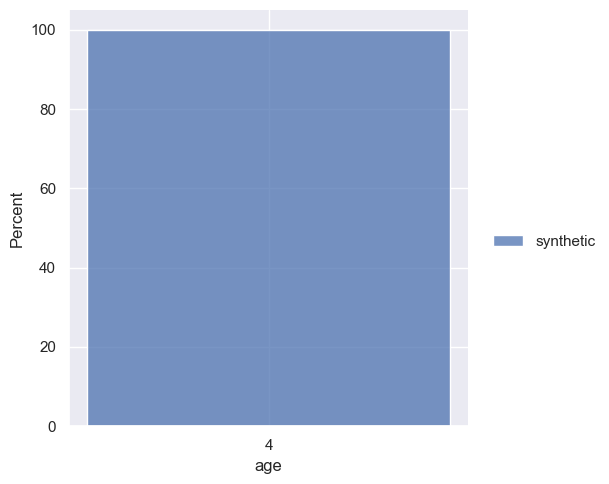

In [14]:
# plot age
rl.vis.plot_bar(datasets=[syn], field="age")

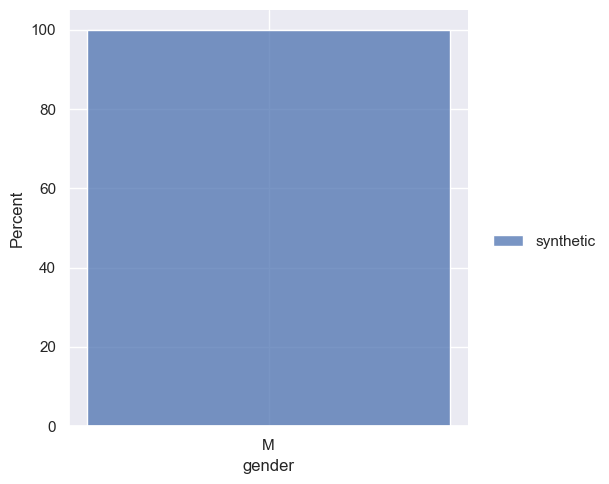

In [15]:
# plot gender
rl.vis.plot_bar(datasets=[syn], field="gender")

#### Example 2: Multiple Conditions, Controlling Number of Sessions

**User Intent**

Generate the following synthetic dataset (using the same model):

1. 25 sessions with metadata (age = 4, gender = M)
2. 50 sessions with metadata either (age = 2, gender = F) or (age = 5, gender = M)


##### Specify these conditions in the generate config


In [16]:
# given_metadata = [(age = 2, gender = F), (age = 5, gender = M)]
# expected output: 50 sessions with metadata that can be either
# (age = 2, gender = F) or (age = 5, gender = M).
given_metadata2 = {"age": ["2", "5"], "gender": ["F", "M"]}
generate2_config = get_config(sessions=50, given_metadata=given_metadata2)
generate2 = ra.GenerateTimeGAN(generate2_config)

##### Run the generate workflow


In [17]:
save = ra.DatasetSave(
    name="synthetic", concat_tables=True, concat_session_key="session_key"
)

# this shows how you can add two different generate actions to the same workflow
builder = rf.WorkflowBuilder()
builder.add(model)
builder.add(
    generate1, parents=[model]
)  # re-using generate action from example 1
builder.add(
    generate2, parents=[model]
)  # using generate action from example 2
builder.add(save, parents=[generate1, generate2])
workflow = await builder.start(conn)
print(f"Generate Workflow: {workflow.id()}")

Generate Workflow: 5OE40Mj69wbGbad07rb2Rd


In [18]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2025-02-07T00:39:16Z generate-time-gan1: DEBUG CUDA available
2025-02-07T00:39:16Z generate-time-gan1: DEBUG Running on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2025-02-07T00:39:17Z generate-time-gan1: INFO Downloading model with model_id='e351308d-e4eb-11ef-a0ee-0e92d88750cd'...
2025-02-07T00:39:18Z generate-time-gan1: INFO Generating 50 sessions...
2025-02-07T00:39:20Z generate-time-gan1: DEBUG Generating data from model trained with 1 epochs
2025-02-07T00:39:20Z generate-time-gan1: DEBUG DG generating 1 batch
2025-02-07T00:39:21Z dataset-save: INFO using field 'session_key' to concatenate tables
2025-02-07T00:39:21Z dataset-save: INFO Saved dataset '5z3JonWZToCwrjC1ppzHFF' with 295 rows
2025-02-07T00:40:56Z generate-time-gan: DEBUG CUDA available
2025-02-07T00:40:56Z generate-time-gan: DEBUG Running on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2025-02-07T00:40:56Z generate-time-gan: INFO Downloading model with model_id='e351308d-e4eb-11ef-a0ee-0e92d88750cd'...
2025-

In [19]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)

In [20]:
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-12 13:51:16.459,4678.341502,4,M,M1053599405,barsandrestaurants,0,50.0
1,2023-01-11 23:20:44.547,4715.285463,4,M,M1600850729,hyper,0,50.0
2,2023-01-12 13:51:16.459,1496.636816,4,M,M209847108,barsandrestaurants,0,51.0
3,2023-01-13 14:49:43.048,2577.609953,4,M,M1872033263,barsandrestaurants,0,51.0
4,2023-01-12 13:51:16.459,4105.203964,4,M,M349281107,barsandrestaurants,1,52.0
...,...,...,...,...,...,...,...,...
368,2023-12-02 18:47:39.838,482.307054,2,F,M732195782,tech,0,48.0
369,2023-12-17 05:23:25.576,358.464400,2,F,M2080407379,wellnessandbeauty,0,48.0
370,2023-12-31 17:44:50.038,266.211484,2,F,M732195782,tech,0,48.0
371,2023-01-19 21:49:14.869,1591.679590,5,M,M1053599405,contents,0,49.0


##### Validate metadata fields are constrained to given_metadata:


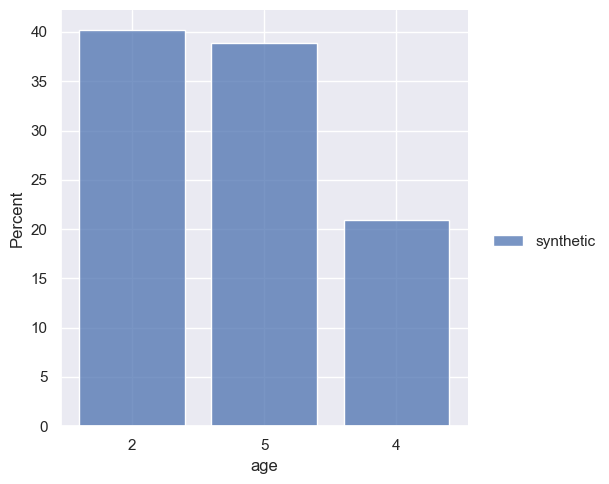

In [21]:
# plot age
rl.vis.plot_bar(datasets=[syn], field="age")

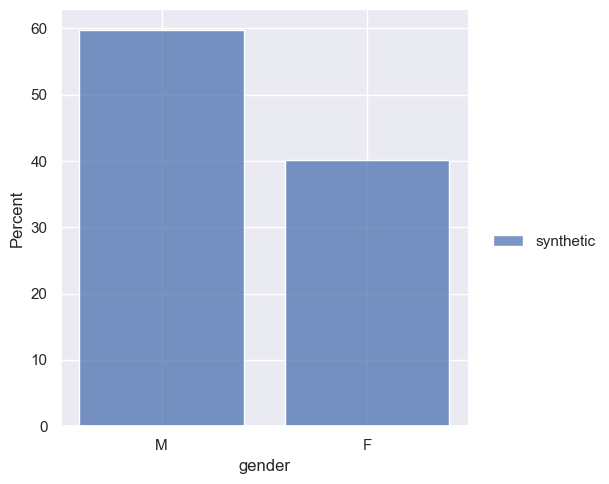

In [23]:
# plot gender
rl.vis.plot_bar(datasets=[syn], field="gender")